In [14]:
#dependencies
import h5py
import pylab
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import utils.plotutils as plu
import utils.imreadin as imr

%matplotlib inline

In [15]:
# Model Parameters
nneurons = 100
patchsize = 128
batchsize = 101
iterations = 10
testiterations = 100

#noise - these Prateek is interested in changing to removed iid asumption
noisexsigma = 0.4 #1e-4
noisersigma = 2 #1e-4

#to keep covariance matrix small for now
npatchestotal =  iterations*batchsize #np.int(1e6)

lambdaj = 1e-5 #this is adjusted in order to get ravg = 1
ravg = 1

minact = 0 #5e-1
minslo = 0 #1e-1
#bslfr = 1e-1

learning_rate = 10


In [16]:
#full images
#vhims = extract_images('../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5')

#image patches (as in Karklin& Simoncelli)
#only load in image patches if we haven't yet.
try:
    vhims
except NameError:
    print("Loading Van Hateren Natural Image Database...")
    vhims = imr.vanHateren(
        img_dir='../vanHaterenNaturalImages/VanHaterenNaturalImagesCurated.h5',
        normalize = True,
        patch_edge_size=patchsize
        )
    print("Done Loading!")    
    #np.random.shuffle(vhims.images)
    print("Done Shuffling!")
    
    ##reduce images so we only hold in memory the ones we're using
    #vhims.images = vhims.images[0:npatchestotal]
    
print("Images Loaded. Carry On!")

#code to save if i had enough hd space. i shold buy a new computer.
#f=open('../vanHaterenNaturalImages/vhnormpatches_{}.npy'.format(patchsize),'wb')
#np.save(f,vhims)
#f.close()

Images Loaded. Carry On!


(73216, 128, 128)


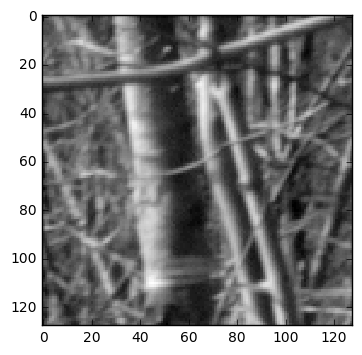

In [17]:
plt.imshow(vhims.images[340],cmap='gray',interpolation='none')
plt.colorbr()

C_x calculated. Shape is (16384, 16384), calculated from (128, 73216) patches.


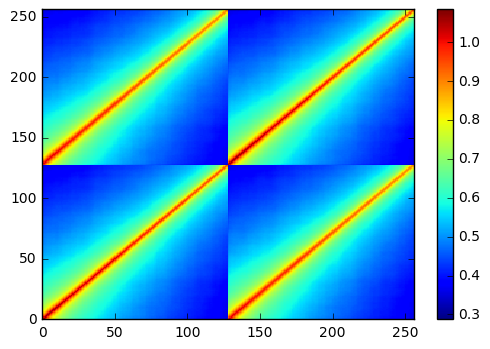

In [18]:
#covariance parameters

#global curvature of images
try:
    cx
    #raise NameErrorException
except NameError:
    print("Couldn't find C_x matrix. Calculating now....")
    xr = np.reshape(np.transpose(vhims.images,(1,2,0)),(patchsize**2,-1))
    #cx = np.cov(xr,rowvar=True)
    cx = np.dot(xr,xr.T)/np.shape(xr)[1]
    #cx = cx - np.dot(np.mean(xr,axis=1,keepdims=True).T,np.mean(xr,axis=1,keepdims=True))

print("C_x calculated. Shape is {}, calculated from {} patches.".format(np.shape(cx),np.shape(xr)))

#cx = np.cov(xr)
#cx = np.array(cx)/np.max(cx)*10**12
#cx=cx/15
#cx = np.dot(xr,xr.T)/npatchestotal - np.dot(np.mean(xr,axis=1,keepdims=True).T,np.mean(xr,axis=1,keepdims=True))
#cx = np.eye(patchsize**2)
#print(cx)
#print(np.linalg.det(cx))
plt.pcolormesh(cx)
plt.xlim(0,patchsize**2)
plt.ylim(0,patchsize**2)
#plt.pcolormesh(cx)
plt.colorbar()

#noise covariances
cnx = np.eye(patchsize**2) * noisexsigma**2
cnr = np.eye(nneurons) * noisersigma**2

In [ ]:
#plt.pcolormesh(cx[0:32,200:256])
plt.pcolormesh(cx[0:patchsize,0:patchsize])
plt.colorbar()

In [ ]:
#input image
x = tf.placeholder(tf.float32, shape=(patchsize**2,batchsize),name='input_image')

#noise
#nx = tf.placeholder(tf.float32, shape=(patchsize**2,batchsize),name='input_noise')
#nr = tf.placeholder(tf.float32, shape=(nneurons,batchsize),name='response_noise')

nx = tf.constant(nxc,dtype=tf.float32,name='input_noise')
nr = tf.constant(nrc,dtype=tf.float32,name='response_noise')

#covariances
cxt = tf.constant(cx,dtype=tf.float32)#+0.01
#cxt = tf.constant(np.eye(patchsize**2),dtype=tf.float32)
cnxt = tf.constant(cnx,dtype=tf.float32)#+0.01
cnrt = tf.constant(cnr,dtype=tf.float32)#+0.01

#weights
w = tf.Variable(tf.random_normal(shape=(patchsize**2,nneurons),dtype=tf.float32,stddev=1),name='weights')
#relu params - both positive
actslope = tf.Variable(np.abs(tf.random_normal([nneurons,1],stddev=1,dtype=tf.float32)),dtype=tf.float32,name='relu_slope')
actoffset = tf.Variable(np.abs(tf.random_normal([nneurons,1],stddev=1,dtype=tf.float32)),dtype=tf.float32,name='relu_offset')
#constant offsets
constoffsets = tf.Variable(tf.random_normal([nneurons,1],stddev=1,dtype=tf.float32),dtype=tf.float32,name='const_offset')


#activation function
def af(slope,offset,y):
    #return(1/(1+tf.exp(-1*slope*(y+offset)))) #sigmoid
    return(tf.mul(tf.abs(slope),tf.nn.relu(tf.add(y,offset)))+minact) #,tf.cast(minact, dtype=float32)) #relu

def af_ddy(slope,offset,y):
    #return(slope*af(slope,offset,y)*(1-af(slope,offset,y))) #sigmoid
    return(tf.mul(tf.cast(tf.less(offset, y),tf.float32),tf.abs(slope))+minslo) #relu

#calculate response
#print(tf.shape(w))
y = tf.batch_matmul(tf.transpose(w),tf.add(x, nx))

#print(y)

g = tf.matrix_diag(tf.transpose(af_ddy(actslope,actoffset,y)))
#gt = tf.transpose(g,[1,2,0])
#print(g)

#r = tf.add(tf.add(tf.batch_matmul(g,y), nr), constoffsets)
r = tf.add(af(actslope,actoffset,y), nr)

indvrate = tf.reduce_mean(r,1)
meanrate = tf.reduce_mean(indvrate)

#objective function: maximize I(X,R)-sum_j(lambda*<r_j>)
#1s for all places respose (y + offset) is greater than zero
#mask = tf.cast(tf.less(tf.zeros((nneurons,1)),y+reluoff),tf.float32)
#multiply response by reluslope everywhere response was greater than zero, add baseline to this.


slopes = af_ddy(actslope,actoffset,y)

crx = tf.matmul(cnxt,w)
crx = tf.matmul(tf.transpose(w),crx)
crx = tf.einsum('ijk,kl->ijl',g,crx)
crx = tf.batch_matmul(crx,g) + cnrt

cxr = tf.matrix_inverse(tf.matrix_inverse(cxt) + tf.einsum('ij,kjl->kil',w,tf.einsum('ijk,kl->ijl',
                        tf.batch_matmul(tf.batch_matmul(g,tf.matrix_inverse(crx)),g),tf.transpose(w))))

det_g = tf.matrix_determinant(g)
detcxrt = tf.matrix_determinant(cxr)

information = -tf.reduce_mean(0.5*tf.log(2*np.pi*np.exp(1)*tf.trace(cxr)+.001),0)
#information = -tf.reduce_mean(0.5*tf.log(2*np.pi*np.exp(1)*detcxrt+.0001),0)

#lambdajs = 1./indvrate
lambdajs = lambdaj
objective =  information - lambdajs * meanrate #/nneurons

train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(-objective)

In [ ]:
#run it!
#sess = tf.Session
with tf.Session() as sess:
    #initialize vars
    init = tf.global_variables_initializer()
    sess.run(init)
    
    #save evolution of system over training
    information_evolution = []
    objective_evolution = []
    rate_evolution = []
    detcxrs_evolution = []
    slopes_evolution = []
    weights_evolution = []
    
    hist = {}
    
    #train over niterations
    nits = iterations #full run
    nits = testiterations #test run
    
    print('Training {} iterations...'.format(nits))
    for ii in range(nits):
        if(ii%(int(nits/10))==0):
            print(str(ii)+', ',end="")
        #image = np.random.rand(patchsize**2,batchsize).astype(np.float32) #random image
        image = np.reshape(vhims.images[ii*batchsize:(1+ii)*batchsize,:,:],(batchsize,patchsize**2)).T.astype(np.float32)
        #noise_input = np.random.normal(0,noisexsigma,[patchsize**2,batchsize]).astype(np.float32)*0.
        #noise_response = np.random.normal(0,noisersigma,[nneurons,batchsize]).astype(np.float32)*0.
        hist[0] = image
        #hist[1] = noise_input
        #hist[2] = noise_response 
        info = sess.run(information, feed_dict={x:image})
        #information_evolution.append(info)
        #print(info)
        #train
        #train_step.run(feed_dict={x:image, nx: noise_input, nr:noise_response})
        sess.run(train_step, feed_dict={x:image})
        
        #save evolution of params
        info = sess.run(information, feed_dict={x:image})
        information_evolution.append(info)
        #print(info)
        cost = sess.run(objective, feed_dict={x:image})
        objective_evolution.append(cost)
        rate = sess.run(indvrate, feed_dict={x:image})
        rate_evolution.append(rate)
        detcxr = sess.run(detcxrt, feed_dict={x:image})
        detcxrs_evolution.append(detcxr)
        slopesr = sess.run(slopes, feed_dict={x:image})
        slopes_evolution.append(slopesr)
        weightsr = sess.run(w, feed_dict={x:image})
        weights_evolution.append(np.std(weightsr))
        #if ii%iterations == 0:
            #pass
        
    #print statements
    #myweights = w.eval()
    #print(myweights)
    #myrlus = reluslope.eval()
    #print(myrlus)
    #myrluof = reluoff.e`val()
    #print(myrluof)
    #myrs = r.eval()
    #print(myrs)
    #myobjective = objective.eval()
    #print(myobjective)
    weights = sess.run(w, feed_dict={x:image})
    detz = sess.run(g, feed_dict={x:image})
    print('Done!')
    

In [ ]:
plt.figure(figsize=(6,6))
plt.subplot(3,1,1,title='Information')
plt.plot(information_evolution)

plt.subplot(3,1,2,title='Firing Rate')
plt.plot(np.mean(rate_evolution,1))

plt.subplot(3,1,3,title='Objective')
plt.plot(objective_evolution)

#plt.subplot(3,1,3,title='stdweights')
#plt.plot(weights_evolution)

#plt.subplot(2,2,4,title='cxrs Determinant')
#plt.plot(detcxrs_evolution)
plt.tight_layout()

In [ ]:
wr = np.rollaxis(np.reshape(weights,(patchsize,patchsize,nneurons)),2)
plu.display_data_tiled(wr, normalize=False, title="weights", prev_fig=None)

In [ ]:
plt.imshow(np.reshape(weights[:,24],(patchsize,patchsize)),interpolation='none',cmap='Greys')
#plt.contour(np.reshape(weights[:,69],(patchsize,patchsize)),interpolation='none')#,cmap='Greys')
plt.colorbar()

## Bonus Code

In [ ]:
### weights
w = np.random.randn(patchsize**2,nneurons)
#relu params - both positive
actslope = np.abs(np.random.randn(nneurons,1))
actoffset = np.abs(np.random.randn(nneurons,1))


def sigmoid_af(slope,offset,y):
    #return(1/(1+tf.exp(-1*slope*(y+offset))))
    return(np.abs(slope)*((y-offset)>0)+minact)

def sigmoid_af_ddy(slope,offset,y):
    #return(slope*sigmoid_af(slope,offset,y)*(1-sigmoid_af(slope,offset,y)))
    mask = (offset[:,0] < y.T)
    return(mask*np.abs(slope[:,0])+minslo)



#calculate response
y = np.transpose(np.dot(np.transpose(hist[0][:,0] + hist[1][:,0]),w))
#print(np.transpose(hist[0] + hist[1]).shape)
#print(w.shape)
#print(y.shape)
r = np.add(sigmoid_af(actslope, actoffset, y), hist[2][:,0])
rate = np.mean(r,0)
#print(rate)

#g = np.diag(np.reshape(sigmoid_af_ddy(actslope,actoffset,y),-1)+0.1) 
g = np.diag(np.reshape(sigmoid_af_ddy(actslope,actoffset,y),[nneurons])+minslo)

print('g')
print(g)
print(np.linalg.det(g))
print(np.trace(g))

print('cxinv')
print(np.linalg.inv(cx))
print(np.linalg.det(np.linalg.inv(cx)))

print('cnx')
print(cnx)
print(np.linalg.det(cnx))

print('cnr')
print(cnr)
print(np.linalg.det(cnr))

cxrp2 = np.dot(w,np.dot(g, 
                        np.dot(np.linalg.inv(
                        np.dot(g,
                        np.dot(np.transpose(w), 
                        np.dot(cnx, 
                        np.dot(w, g)))) + cnr),
                        np.dot(g, np.transpose(w)))))


cxr = np.linalg.inv(np.linalg.inv(cx) + #with inverse calculated by Shariq
#cxr =  1 * (tf.matrix_inverse(cx) + #as in paper
                        cxrp2)

print('cxr')
print(np.linalg.det(cxr))
print(cxr)

print('cxrp2')
print(np.linalg.det(cxrp2))
print(cxrp2)


print('gwcwg')
pgwcwg = np.linalg.inv(np.dot(g,np.dot(w.T,np.dot(cnx,np.dot(w,g))))+cnr)
gwcwg = np.dot(w,np.dot(g,np.dot(pgwcwg,np.dot(g,w.T))))+np.linalg.inv(cx)
print(gwcwg)

print(np.linalg.det(gwcwg))

print('w')
print(w)
#print(np.linalg.det(w))


plt.pcolormesh(gwcwg)
plt.colorbar()

information = np.mean(0.5*np.log1p(2*np.pi*np.exp(1)*(np.linalg.det(cxr))))
objective =  information - np.sum(lambdaj * rate)#/nneurons

print(information)
#train_step = tf.train.GradientDescentOptimizer(learning_rate).minimize(-objective)

In [ ]:
plt.pcolormesh(np.linalg.inv(cx))
plt.colorbar()

In [ ]:
plt.pcolormesh(cx)
plt.colorbar()